<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')

# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)

# Drop individual category ratings
df_reviews.drop(columns=cols, inplace=True)

In [4]:
df_reviews.head()

,Title,Content,average_score
0,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

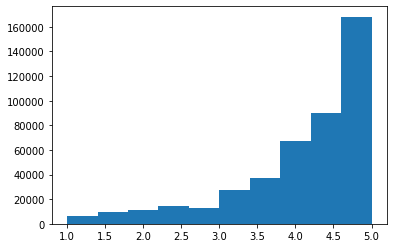

In [5]:
plt.hist(df_reviews['average_score'], bins=10);

### Sample titles and descriptions by average score

In [6]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“Do you like fleas?” 
 Score =  1.00
We stayed in a room that someone must had a pet in before us because all four of us got fleas from the beds while staying here. Pick
somewhere else


“They got my kids clothes and did not returned” 
 Score =  1.00
Im truly disappointed with this hotel, it has a musty smell and looks like it has not been properly cleaned. The front desks esp the lady in
the morning shift is rude and snaps to frustrated guest. The worst thing that happened to us is while we are out during the day,
housekeeping took my kids used clothes that was inside a laundry bag/ plastic bag and was never returned. I have followed this up on day 2
until day 5 but have never had any clear answer and did not even apologize, this has been reached the manager but he never help us. Don't
ever stay in this hotel, if it was not for the time share, we have check out the next day. And anyway Internet access is so poor, towels are
not being replaced!


“Terrible” 
 Score =  

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

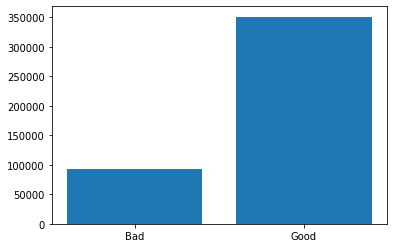

In [7]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

In [18]:
baseline = df_reviews[df_reviews['sentiment'] == 1]['sentiment'].count() / df_reviews['sentiment'].count()
print(f'Baseline (probability of being accurate if we just guess all are ones): {baseline * 100: .2f}%')

Baseline (probability of being accurate if we just guess all are ones):  79.06%


### Clean text

1) Remove curly quotation marks from titles

2) Concatenate titles and description as Content

3) Remove punctuation and stopwords

In [19]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Content,average_score,sentiment
0,super stay second time stayed time son family ...,5.000000,1
1,permanent improvements various aereas highligh...,4.571429,1
2,span pacific orchard great hotel good location...,4.571429,1
3,great value money heart shopping district pan ...,4.714286,1
4,pan pacific orchard stayed 3 nights hotel clea...,4.571429,1
